In [1]:
import pandas as pd
# import scprep as sc
import scanpy as sc
import phate
import numpy as np
import seaborn as sns
import scprep
from sklearn.metrics import roc_auc_score, average_precision_score
import os
from tqdm import tqdm
import warnings


In [ ]:
from tqdm import tqdm
import warnings
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss


def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


from statsmodels.tsa.stattools import grangercausalitytests

lag_order = 1
maxlag = (
    lag_order,  # becuase we got this value before. We are not suppose to add 1 to it
)
test = "ssr_chi2test"

from joblib import Parallel, delayed

def grangers_causation_matrix(
    data, in_variables, out_variables, test="ssr_chi2test", n_jobs=1, warn=False
):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    def get_pval(dd):
        if warn:
            test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)
                test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=False)
                # according to the documentation https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html,
                # the dd has 2 columns, second causes the first.
        p_values = [test_result[i][0][test][1] for i in maxlag]
        min_p_value = np.min(p_values)
        return min_p_value

    out = Parallel(n_jobs=n_jobs)(
        # delayed(get_pval)(data[[r, c]]) # this is incorrect
        delayed(get_pval)(data[[c, r]]) # this means r causes c, so r is be in and c is out
        for c in tqdm(out_variables, desc="Processing columns")  # Outer loop progress bar
        for r in tqdm(in_variables, desc="Processing rows", leave=False)  # Inner loop progress bar
    )
    # Note that this is the wrong way and must be corrected
    # df = pd.DataFrame(
    #     np.array(out).reshape((len(in_variables), len(out_variables))), # this is incorrect
    #     columns=out_variables,
    #     index=in_variables,
    # )
    df = pd.DataFrame(
        np.array(out).reshape((len(out_variables), len(in_variables))), # should be reshaped to len(out_variables), len(in_variables) according to the for loop.
        columns=in_variables,
        index=out_variables,
    ).T # used the correct reshaping, and then transposed the matrix so the x and y are semantically correct (x causes y).
    df.index = [var + "_x" for var in in_variables]
    df.columns = [var + "_y" for var in out_variables]
    return df

def do_granger(trajs, in_genes, out_genes, n_jobs=1, warn=False):
    # in causes out
    # trajs = trajs.T[::10]
    trajs = trajs.T # do not shorten it
    trajs = trajs - trajs.shift(1)
    trajs = trajs.dropna()
    out_traj = grangers_causation_matrix(
        trajs, in_variables=in_genes, out_variables=out_genes, n_jobs=n_jobs, warn=warn
    )
    return out_traj

In [ ]:
# traj_gene_sp = np.load("../data_human_samples/10-trajectories_gene_space.npy")
traj_gene_sp = np.load(f"../results_final_Dec22/traj_gene_space_T.npy", allow_pickle=True)

In [4]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [5]:
# sc.pp.highly_variable_genes(adata, n_top_genes=400)
alex_genes = open('../data/alex_genes.txt').read().splitlines()
alex_tfs = open('../data/alex_tfs.txt').read().splitlines()

In [6]:
# gene_mask = np.isin(adata.var_names, alex_genes)
# tf_mask = np.isin(adata.var_names, alex_tfs)

In [7]:
alex_gene_all = list(set(alex_genes) | set(alex_tfs))
alex_gene_all_mask = np.isin(adata.var_names, alex_gene_all)
traj_subset = traj_gene_sp[:, :, alex_gene_all_mask]
gene_names = adata.var_names[alex_gene_all_mask]

In [8]:
traj_subset.shape

(100, 92, 2226)

In [9]:
# traj_df = pd.DataFrame(np.transpose(traj_subset, (1, 0, 2)).mean(axis=0), columns=gene_names)
data = np.transpose(traj_subset, (1, 0, 2))
valid_mask = (data.mean(axis=0).var(axis=0) != 0.0)
data = data[:, :, valid_mask]
gene_names = np.array(gene_names)[valid_mask]
traj_df = pd.DataFrame(data.mean(axis=0), columns=gene_names)

In [14]:
gm = do_granger(traj_df.T, in_genes=alex_tfs, out_genes=alex_genes, n_jobs=-1)

Processing columns:   0%|          | 7/1970 [00:06<27:30,  1.19it/s]

KeyboardInterrupt: 

0.37986383388752


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-1.20136166e-01, -1.10136166e-01, -1.00136166e-01, -9.01361661e-02,
        -8.01361661e-02, -7.01361661e-02, -6.01361661e-02, -5.01361661e-02,
        -4.01361661e-02, -3.01361661e-02, -2.01361661e-02, -1.01361661e-02,
        -1.36166112e-04,  9.86383389e-03,  1.98638339e-02,  2.98638339e-02,
         3.98638339e-02,  4.98638339e-02,  5.98638339e-02,  6.98638339e-02,
         7.98638339e-02,  8.98638339e-02,  9.98638339e-02,  1.09863834e-01,
         1.19863834e-01,  1.29863834e-01,  1.39863834e-01,  1.49863834e-01,
         1.5986383

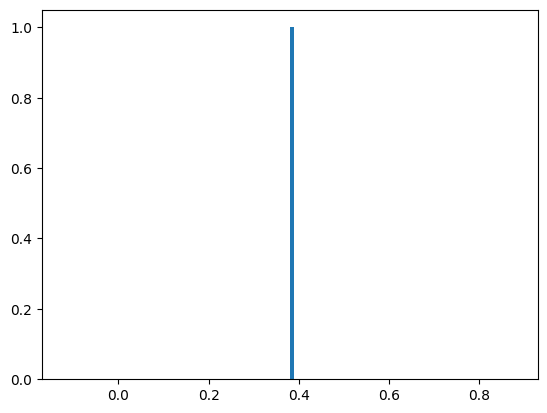

In [ ]:
print(gm.values.min())
import matplotlib.pyplot as plt
plt.hist(gm.values.flatten(), bins=100)

In [ ]:
gm.to_csv(f'../results_final_Dec22/granger_T.csv')